In [21]:
#!/usr/bin/env python
import numpy as np
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.cosmology import FlatLambdaCDM
from astropy.table import Table
import GCRCatalogs
from shear_azimuthal_averager import ShearAzimuthalAverager

### Read in the extragalactic catalog
- identify the most massive halo
- create a cluster dictionary (ra, dec, z)

In [22]:
extragalactic_cat = GCRCatalogs.load_catalog('proto-dc2_v2.1.2_test')

# get a massive halo!
massive_halos = extragalactic_cat.get_quantities(['halo_mass', 'redshift','ra', 'dec'],\
                                                 filters=['halo_mass > 1e14','is_central==True'])

m = massive_halos['halo_mass']
select = (m == np.max(m))
ra_cl = massive_halos['ra'][select][0]
dec_cl = massive_halos['dec'][select][0]
z_cl = massive_halos['redshift'][select][0]
print(m[select], ra_cl, dec_cl, z_cl)

# make a dictionary for cluster
cl_dict = {'z':z_cl, 'ra':ra_cl, 'dec': dec_cl}


/global/common/software/lsst/common/miniconda/py3-4.3.21-env/envs/clmassmod-nostack/lib/python3.6/site-packages/GCRCatalogs/alphaq.py:105: UserWarning: No md5 sum specified in the config file
  warnings.warn('No md5 sum specified in the config file')


[  5.95588752e+14] 1.15419 2.20399 0.354081722946


### Apply coordinates and redshift cuts to select backgroud galaxies around the cluster

In [6]:
# get galaxies around it
ra_min, ra_max = ra_cl-0.3, ra_cl+0.3
dec_min, dec_max = dec_cl-0.3, dec_cl+0.3
z_min = z_cl + 0.1
z_max = 1.5

coord_filters = [
    'ra >= {}'.format(ra_min),
    'ra < {}'.format(ra_max),
    'dec >= {}'.format(dec_min),
    'dec < {}'.format(dec_max),
]
z_filters = ['redshift >= {}'.format(z_min),'redshift < {}'.format(z_max)]

gal_cat = extragalactic_cat.get_quantities(['galaxy_id', 'ra', 'dec', 'shear_1', 'shear_2', 'shear_2_phosim', 'shear_2_treecorr',\
                                            'redshift', 'convergence'], filters=(coord_filters + z_filters))

# store the results into an astropy table
t = Table([gal_cat['galaxy_id'],gal_cat['ra'],gal_cat['dec'],gal_cat['shear_1'],\
          gal_cat['shear_2'],gal_cat['redshift'],gal_cat['convergence']], \
          names=('id','ra','dec', 'gamma1', 'gamma2', 'z', 'kappa'))


### Computes the tangential and cross shear profiles

#### Default binning

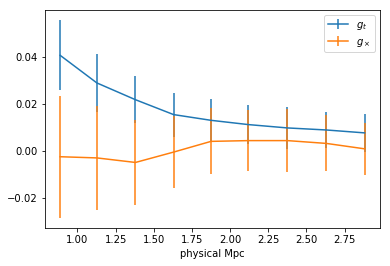

In [14]:
# create an object, given cluster dictionary and galaxy astropy table
saa = ShearAzimuthalAverager(cl_dict,t)

# compute tangential and cross shear for each galaxy
saa.compute_shear()

# make the binned profile
binned_profile = saa.make_shear_profile()

saa.plot_profile()   

#### User-defined binning

In [19]:
bins = [0., 0.2, 0.5, 0.7, 1.1]
binned_profile2 = saa.make_shear_profile(bins=bins)
binned_profile2

radius,ang_seperation,g_t,g_x,g_t_err,g_x_err
Mpc,rad,,,,
float64,float64,float64,float64,float64,float64
0.14397379756,0.000140245712828,0.0137931983918,0.00110310455784,0.0135762933642,0.0159622039646
0.384573996067,0.000374615745386,0.0412072390318,0.000374475930585,0.016274612397,0.0329268276691
0.610790014267,0.000594974146225,0.0448293946683,-0.0115267373621,0.0117022860795,0.0339368470013
0.923779428005,0.000899858947378,0.0384341701865,-0.00319075305015,0.0146962702274,0.026199484244


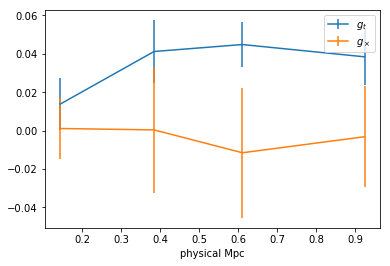

In [16]:
saa.plot_profile()